## Solving a Sudoku Puzzle Using Grover's Algorithm
Consider a 2x2 sudoku puzzle in which every square has to contain either one or zero. You can't have the same value in the horizontal or vertical.

|       |       |
|-------|-------|
| $v_0$ | $v_1$ |
| $v_2$ | $v_3$ |


Horizontals:

$v_0 \neq v_1$

$v_2 \neq v_3$

Veritcals:

$v_0 \neq v_2$

$v_1 \neq v_3$


## Imports

In [55]:
import numpy as np
from qiskit import *
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *

## XOR Gate
This is just to make comparing the value of qubits easier

In [2]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

## The Oracle 

In [60]:
def sudoku_oracle(var_qubits, clause_qubits, output_qubits, clause_list):
    
    qc = QuantumCircuit(var_qubits, clause_qubits, output_qubits, name='Oracle')
    
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1
    
    return qc

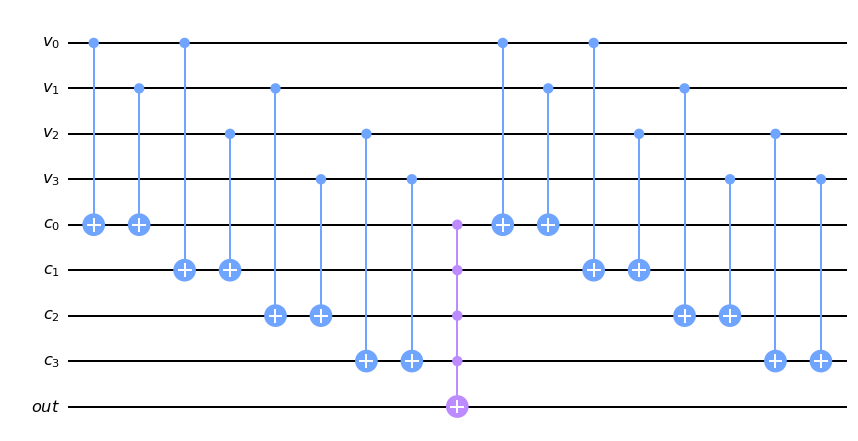

In [61]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubits = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')

qc = sudoku_oracle(var_qubits, clause_qubits, output_qubits, clause_list)
qc.draw(output='mpl')

## The Diffuser
This functions the same as before in Grover's Algorithm

In [7]:
def diffuser(n):
    qc = QuantumCircuit(n, name='Diffuser')
    
    for qubit in range(n):
        qc.h(qubit)
    
    for qubit in range(n):
        qc.x(qubit)
    
    # Multi-controlled-Z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    
    for qubit in range(n):
        qc.x(qubit)
    
    for qubit in range(n):
        qc.h(qubit)
    
    return qc

## The Circuit

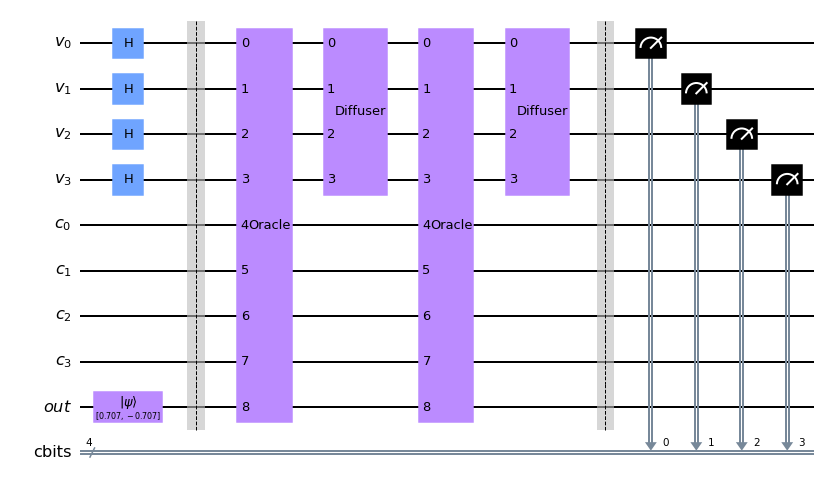

In [63]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubits = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier() 

## First Iteration
qc.append(sudoku_oracle(var_qubits, clause_qubits, output_qubits, clause_list), list(range(9)))
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
qc.append(sudoku_oracle(var_qubits, clause_qubits, output_qubits, clause_list), list(range(9)))
qc.append(diffuser(4), [0,1,2,3])
qc.barrier()

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(output='mpl',fold=-1)

## Simulating the Algorithm

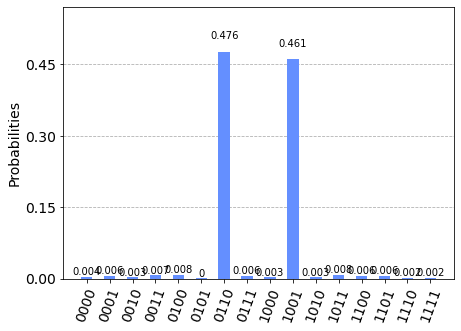

In [64]:
sim = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = sim, shots = 1024).result()
counts = result.get_counts()
plot_histogram(counts)